In [68]:
%pip install pandas tabula-py rdflib pydotplus pyshacl pykeen scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [69]:
import os
import io
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display, Image
from rdflib import Graph, Namespace, Literal, RDF, RDFS, XSD, URIRef
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from rdflib.tools.rdf2dot import rdf2dot
import pydotplus


In [36]:
pdf_files = [f for f in os.listdir(directory) if f.endswith('.pdf')]

for pdf_file in pdf_files:
    pdf_file_name = re.sub('.pdf', '', pdf_file)
    file_path = os.path.join(directory, pdf_file)
    tabula.convert_into(file_path, f"{directory}/{pdf_file_name}.csv", output_format="csv", pages='all')
    print(f"Converted {pdf_file} to csv")


Converted ufo_report_2008.pdf to csv
Converted UFOReport1999.pdf to csv
Converted UFOReports2003WholeoftheUK.pdf to csv
Converted UFOReport2000.pdf to csv
Converted UFOReports2006WholeoftheUK.pdf to csv
Converted UFOReports2002WholeoftheUK.pdf to csv
Converted ufo_report_2007.pdf to csv
Converted ufo_report_2009.pdf to csv
Converted UFOReports2005WholeoftheUK.pdf to csv
Converted ufo_report_1997.pdf to csv
Converted UFOReport2001.pdf to csv
Converted UFOReports2004WholeoftheUK.pdf to csv
Converted UFOReport1998.pdf to csv


In [50]:


directory = 'data/uk'
all_csv_files = [f for f in os.listdir(directory) if re.search(r'\.csv$', f)]

# Initialize an empty DataFrame to store combined data
combined_csv_data = pd.DataFrame()

# Define the new column names
new_column_names = ['date', 'time', 'city', 'area', 'occupation of reporter', 'description']

# Define a function to map old column names to new column names based on patterns
def rename_columns(columns):
    column_mapping = {
        re.compile(r'date', re.IGNORECASE): 'date',
        re.compile(r'time', re.IGNORECASE): 'time',
        re.compile(r'(town|village|city)', re.IGNORECASE): 'city',
        re.compile(r'county|area', re.IGNORECASE): 'area',
        re.compile(r'occupation', re.IGNORECASE): 'occupation of reporter',
        re.compile(r'description', re.IGNORECASE): 'description'
    }
    new_columns = []
    for col in columns:
        for pattern, new_name in column_mapping.items():
            if pattern.search(col):
                new_columns.append(new_name)
                break
        else:
            new_columns.append(col)  # Keep the original column name if no pattern matches

    # Ensure the columns are unique
    unique_columns = []
    seen = set()
    for col in new_columns:
        if col in seen:
            counter = 1
            new_col = f"{col}_{counter}"
            while new_col in seen:
                counter += 1
                new_col = f"{col}_{counter}"
            unique_columns.append(new_col)
            seen.add(new_col)
        else:
            unique_columns.append(col)
            seen.add(col)

    return unique_columns

# Iterate over each CSV file and concatenate them into one DataFrame
for csv_file in all_csv_files:
    file_path = os.path.join(directory, csv_file)
    try:
        temp_df = pd.read_csv(file_path, on_bad_lines='skip')
        temp_df.columns = rename_columns(temp_df.columns)  # Rename the columns
        # Drop unnamed columns
        temp_df = temp_df.loc[:, ~temp_df.columns.str.contains('^Unnamed')]
        combined_csv_data = pd.concat([combined_csv_data, temp_df], ignore_index=True)
    except pd.errors.ParserError as e:
        print(f"Error parsing {file_path}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred with {file_path}: {e}")

# Add the 'country' column with the value 'UK' for all rows
combined_csv_data['country'] = 'UK'
combined_csv_data = combined_csv_data[['date', 'time', 'city', 'area', 'country', 'description']]
combined_csv_data ['date'] = combined_csv_data ['date'].apply() 

# Save the combined data into a single CSV file
combined_csv_data.to_csv(os.path.join('data', 'uk_ufo_sightings.csv'), index=False)
print("All CSV files have been combined into one CSV file.")


All CSV files have been combined into one CSV file.


In [8]:
import pandas as pd
uk = pd.read_csv('data/uk_ufo_sightings.csv')
uk.head(50)

,date,time,city,area,country,description
0,01-Jan-00,07:30,Tenbury Wells,Shropshire,UK,"A cigar shaped object. Grey in colour, with tw..."
1,03-Jan-00,20:45,Evanton,Ross-Shire,UK,"A gold disc was seen. It flew through cloud, r..."
2,04-Jan-00,00:30,Erdingham/Birmingham,West Midlands,UK,"One large, triangular shaped object. There wer..."
3,05-Jan-00,01:20,Wootton Bassett,Wiltshire,UK,One single object. Changed from white to green...
4,09-Jan-00,02:45,Runcorn,Cheshire,UK,"One round, golf ball shaped object. Orange and..."
5,09-Jan-00,21:36,Barnstable,Devon,UK,One cylindrical object. Blue and green in colo...
6,09-Jan-00,18:06,NaN,Cheshire,UK,The object eclipsed the moon. The object was a...
7,13-Jan-00,23:45,Motherwell,Lanarkshire,UK,"One, pulsating orange ball. Object was travell..."
8,14-Jan-00,NaN,NaN,London,UK,"A floating object, sitting in front of a cloud..."
9,17-Jan-00,21:20,Leeds,West Yorkshire,UK,Disc that was illuminated. About 200 ft up and...


In [9]:

us = pd.read_csv('data/us_ufo_sightings.csv')
us.head(10)

,date_time,city_area,state,country,ufo_shape,encounter_length,described_encounter_length,description,date_documented,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300.0,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889
6,10/10/1965 21:00,penarth (uk/wales),NaN,gb,circle,180.0,about 3 mins,penarth uk circle 3mins stayed 30ft above m...,2/14/2006,51.434722,-3.180000
7,10/10/1965 23:45,norwalk,ct,us,disk,1200.0,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333
8,10/10/1966 20:00,pell city,al,us,disk,180.0,3 minutes,Strobe Lighted disk shape object observed clos...,3/19/2009,33.586111,-86.286111
9,10/10/1966 21:00,live oak,fl,us,disk,120.0,several minutes,Saucer zaps energy from powerline as my pregna...,5/11/2005,30.294722,-82.984167


In [12]:

#uk = pd.concat([pd.read_csv(f"{directory}/{f}") for f in os.listdir(directory) if f.endswith('.csv')])
#uk.head(50)
us.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date_time                   80332 non-null  object 
 1   city_area                   80332 non-null  object 
 2   state                       74535 non-null  object 
 3   country                     70662 non-null  object 
 4   ufo_shape                   78400 non-null  object 
 5   encounter_length            80329 non-null  float64
 6   described_encounter_length  80332 non-null  object 
 7   description                 80317 non-null  object 
 8   date_documented             80332 non-null  object 
 9   latitude                    80331 non-null  float64
 10  longitude                   80332 non-null  float64
dtypes: float64(3), object(8)
memory usage: 6.7+ MB


In [58]:
import pandas as pd
us_data =pd.read_csv('data/us_ufo_sightings.csv')
us_data = us_data.head(100)

In [59]:
# Define Namespace
ufo = Namespace("https://example.org/ufo/")

# Create RDF graph
g = Graph()
g.bind("ufo", ufo)

# Data modeling and conceptualization
rdfttl = """
@prefix : <https://example.org/ufo#> .
@prefix ufo: <https://example.org/ufo#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@base <https://example.org/ufo#> .

<https://example.org/ufo> rdf:type owl:Ontology .

#################################################################
#    Object Properties
#################################################################

###  https://example.org/ufo#occurredAt
ufo:occurredAt rdf:type owl:ObjectProperty ;
               rdfs:domain ufo:Sighting ;
               rdfs:range ufo:Location .

###  https://example.org/ufo#hasShape
ufo:hasShape rdf:type owl:ObjectProperty ;
             rdfs:domain ufo:Sighting ;
             rdfs:range ufo:UFOShape .

###  https://example.org/ufo#reportedBy
ufo:reportedBy rdf:type owl:ObjectProperty ;
               rdfs:domain ufo:Sighting ;
               rdfs:range ufo:Witness .

###  https://example.org/ufo#usesEquipment
ufo:usesEquipment rdf:type owl:ObjectProperty ;
                  rdfs:domain ufo:Sighting ;
                  rdfs:range ufo:Equipment .

###  https://example.org/ufo#relatedTo
ufo:relatedTo rdf:type owl:ObjectProperty ;
              rdfs:domain ufo:Sighting ;
              rdfs:range ufo:Sighting .

###  https://example.org/ufo#hasPhysicalEvidence
ufo:hasPhysicalEvidence rdf:type owl:ObjectProperty ;
                        rdfs:domain ufo:Sighting ;
                        rdfs:range ufo:PhysicalEvidence .

###  https://example.org/ufo#observedDuring
ufo:observedDuring rdf:type owl:ObjectProperty ;
                   rdfs:domain ufo:Sighting ;
                   rdfs:range ufo:WeatherCondition .

#################################################################
#    Data Properties
#################################################################

###  https://example.org/ufo#date
ufo:date rdf:type owl:DatatypeProperty ;
         rdfs:domain ufo:Sighting ;
         rdfs:range xsd:date .

###  https://example.org/ufo#time
ufo:time rdf:type owl:DatatypeProperty ;
         rdfs:domain ufo:Sighting ;
         rdfs:range xsd:time .

###  https://example.org/ufo#description
ufo:description rdf:type owl:DatatypeProperty ;
                rdfs:domain ufo:Sighting ;
                rdfs:range xsd:string .

###  https://example.org/ufo#encounterLength
ufo:encounterLength rdf:type owl:DatatypeProperty ;
                    rdfs:domain ufo:Sighting ;
                    rdfs:range xsd:float .

###  https://example.org/ufo#describedEncounterLength
ufo:describedEncounterLength rdf:type owl:DatatypeProperty ;
                             rdfs:domain ufo:Sighting ;
                             rdfs:range xsd:string .

###  https://example.org/ufo#dateDocumented
ufo:dateDocumented rdf:type owl:DatatypeProperty ;
                   rdfs:domain ufo:Sighting ;
                   rdfs:range xsd:date .

###  https://example.org/ufo#latitude
ufo:latitude rdf:type owl:DatatypeProperty ;
             rdfs:domain ufo:Location ;
             rdfs:range xsd:float .

###  https://example.org/ufo#longitude
ufo:longitude rdf:type owl:DatatypeProperty ;
              rdfs:domain ufo:Location ;
              rdfs:range xsd:float .

###  https://example.org/ufo#city
ufo:city rdf:type owl:DatatypeProperty ;
         rdfs:domain ufo:City ;
         rdfs:range xsd:string .

###  https://example.org/ufo#state
ufo:state rdf:type owl:DatatypeProperty ;
          rdfs:domain ufo:State ;
          rdfs:range xsd:string .

###  https://example.org/ufo#country
ufo:country rdf:type owl:DatatypeProperty ;
            rdfs:domain ufo:Country ;
            rdfs:range xsd:string .

###  https://example.org/ufo#temperature
ufo:temperature rdf:type owl:DatatypeProperty ;
                rdfs:domain ufo:WeatherCondition ;
                rdfs:range xsd:float .

###  https://example.org/ufo#humidity
ufo:humidity rdf:type owl:DatatypeProperty ;
             rdfs:domain ufo:WeatherCondition ;
             rdfs:range xsd:float .

###  https://example.org/ufo#visibility
ufo:visibility rdf:type owl:DatatypeProperty ;
               rdfs:domain ufo:WeatherCondition ;
               rdfs:range xsd:float .

#################################################################
#    Classes
#################################################################

###  https://example.org/ufo#Sighting
ufo:Sighting rdf:type owl:Class ;
             rdfs:subClassOf ufo:Event .

###  https://example.org/ufo#Location
ufo:Location rdf:type owl:Class ;
             rdfs:subClassOf ufo:Place .

###  https://example.org/ufo#Country
ufo:Country rdf:type owl:Class ;
            rdfs:subClassOf ufo:Location .

###  https://example.org/ufo#State
ufo:State rdf:type owl:Class ;
          rdfs:subClassOf ufo:Location .

###  https://example.org/ufo#City
ufo:City rdf:type owl:Class ;
         rdfs:subClassOf ufo:Location .

###  https://example.org/ufo#UFOShape
ufo:UFOShape rdf:type owl:Class ;
             rdfs:subClassOf ufo:Object .

###  https://example.org/ufo#Event
ufo:Event rdf:type owl:Class .

###  https://example.org/ufo#Place
ufo:Place rdf:type owl:Class .

###  https://example.org/ufo#Object
ufo:Object rdf:type owl:Class .

###  https://example.org/ufo#Witness
ufo:Witness rdf:type owl:Class ;
            rdfs:subClassOf ufo:Person .

###  https://example.org/ufo#Person
ufo:Person rdf:type owl:Class .

###  https://example.org/ufo#Equipment
ufo:Equipment rdf:type owl:Class ;
              rdfs:subClassOf ufo:Object .

###  https://example.org/ufo#PhysicalEvidence
ufo:PhysicalEvidence rdf:type owl:Class ;
                     rdfs:subClassOf ufo:Evidence .

###  https://example.org/ufo#Evidence
ufo:Evidence rdf:type owl:Class .

###  https://example.org/ufo#WeatherCondition
ufo:WeatherCondition rdf:type owl:Class .

###  https://example.org/ufo#Aircraft
ufo:Aircraft rdf:type owl:Class ;
             rdfs:subClassOf ufo:Equipment .

###  https://example.org/ufo#Radar
ufo:Radar rdf:type owl:Class ;
          rdfs:subClassOf ufo:Equipment .

###  https://example.org/ufo#Camera
ufo:Camera rdf:type owl:Class ;
           rdfs:subClassOf ufo:Equipment .

###  https://example.org/ufo#Photograph
ufo:Photograph rdf:type owl:Class ;
               rdfs:subClassOf ufo:PhysicalEvidence .

###  https://example.org/ufo#Sample
ufo:Sample rdf:type owl:Class ;
           rdfs:subClassOf ufo:PhysicalEvidence .

###  https://example.org/ufo#Video
ufo:Video rdf:type owl:Class ;
          rdfs:subClassOf ufo:PhysicalEvidence .

#################################################################
#    General axioms
#################################################################

# Ensure that a Sighting must have a date
[ rdf:type owl:Restriction ;
  owl:onProperty ufo:date ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Sighting
] .

# Ensure that a Sighting must have a location
[ rdf:type owl:Restriction ;
  owl:onProperty ufo:occurredAt ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Sighting
] .

# Ensure that a Sighting must have a shape
[ rdf:type owl:Restriction ;
  owl:onProperty ufo:hasShape ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Sighting
] .

# Ensure that a Sighting must have a witness
[ rdf:type owl:Restriction ;
  owl:onProperty ufo:reportedBy ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Sighting
] .

# Ensure that a Location must have latitude and longitude
[ rdf:type owl:Restriction ;
  owl:onProperty ufo:latitude ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Location
] .

[ rdf:type owl:Restriction ;
  owl:onProperty ufo:longitude ;
  owl:minCardinality 1 ;
  rdfs:subClassOf ufo:Location
] .
"""

# Parse RDF Turtle data
g.parse(data=rdfttl, format="turtle")

# Function to convert date formats
def convert_us_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M').strftime('%Y-%m-%d')
    except ValueError:
        return None

def convert_us_time(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M').strftime('%H:%M:%S')
    except ValueError:
        return None

# Add US data to RDF graph
for idx, row in us_data.iterrows():
    sighting_uri = ufo[f"Sighting_US_{idx+1}"]
    location_uri = ufo[f"Location_US_{idx+1}"]

    date = convert_us_date(row['date_time'])
    time = convert_us_time(row['date_time'])
    date_documented = convert_us_date(row['date_documented'])

    if date and time:
        g.add((sighting_uri, RDF.type, ufo.Sighting))
        g.add((sighting_uri, ufo.date, Literal(date, datatype=XSD.date)))
        g.add((sighting_uri, ufo.time, Literal(time, datatype=XSD.time)))
        g.add((sighting_uri, ufo.description, Literal(row['description'], datatype=XSD.string)))
        g.add((sighting_uri, ufo.encounterLength, Literal(row['encounter_length'], datatype=XSD.float)))
        g.add((sighting_uri, ufo.describedEncounterLength, Literal(row['described_encounter_length'], datatype=XSD.string)))
        if date_documented:
            g.add((sighting_uri, ufo.dateDocumented, Literal(date_documented, datatype=XSD.date)))
        g.add((sighting_uri, ufo.hasShape, Literal(row['ufo_shape'], datatype=XSD.string)))

        # Add location details
        g.add((location_uri, RDF.type, ufo.Location))
        g.add((location_uri, ufo.city, Literal(row['city_area'], datatype=XSD.string)))
        g.add((location_uri, ufo.state, Literal(row['state'], datatype=XSD.string)))
        g.add((location_uri, ufo.country, Literal(row['country'], datatype=XSD.string)))
        g.add((location_uri, ufo.latitude, Literal(float(row['latitude']), datatype=XSD.float)))
        g.add((location_uri, ufo.longitude, Literal(float(row['longitude']), datatype=XSD.float)))
        g.add((sighting_uri, ufo.occurredAt, location_uri))

# Serialize the graph to Turtle format and save it to a file
with open("ufo_knowledge_graph.ttl", "w") as f:
    f.write(g.serialize(format="turtle"))

# Print the serialized graph
print(g.serialize(format="turtle"))


@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ufo: <https://example.org/ufo/> .
@prefix ufo1: <https://example.org/ufo#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://example.org/ufo> a owl:Ontology .

ufo1:Aircraft a owl:Class ;
    rdfs:subClassOf ufo1:Equipment .

ufo1:Camera a owl:Class ;
    rdfs:subClassOf ufo1:Equipment .

ufo1:Photograph a owl:Class ;
    rdfs:subClassOf ufo1:PhysicalEvidence .

ufo1:Radar a owl:Class ;
    rdfs:subClassOf ufo1:Equipment .

ufo1:Sample a owl:Class ;
    rdfs:subClassOf ufo1:PhysicalEvidence .

ufo1:Video a owl:Class ;
    rdfs:subClassOf ufo1:PhysicalEvidence .

ufo1:city a owl:DatatypeProperty ;
    rdfs:domain ufo1:City ;
    rdfs:range xsd:string .

ufo1:country a owl:DatatypeProperty ;
    rdfs:domain ufo1:Country ;
    rdfs:range xsd:string .

ufo1:dateDocumented a owl:DatatypeProperty ;
    rdfs:domain ufo1:Sighting ;
    rdfs:range xsd:date .

ufo1:describ

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.228839 to fit



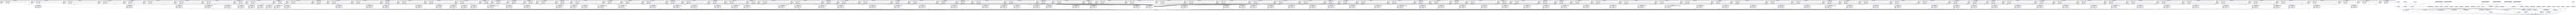

In [9]:
# Generate the graph visualization
stream = io.StringIO()
rdf2dot(g, stream, opts={})
dg = pydotplus.graph_from_dot_data(stream.getvalue())
png = dg.create_png()

# Display the graph
display(Image(png))

In [10]:
from rdflib.plugins.sparql import prepareQuery

# SPARQL query to retrieve all UFO sightings with their descriptions and dates
query1 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    SELECT ?sighting ?description ?date
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:description ?description ;
                ufo:date ?date .
    }
""")

# Execute the query and print the results
for row in g.query(query1):
    print(f"Sighting: {row.sighting}, Description: {row.description}, Date: {row.date}")


Sighting: https://example.org/ufo/Sighting_US_1, Description: This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit, Date: 1949-10-10
Sighting: https://example.org/ufo/Sighting_US_2, Description: 1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime., Date: 1949-10-10
Sighting: https://example.org/ufo/Sighting_US_3, Description: Green/Orange circular disc over Chester&#44 England, Date: 1955-10-10
Sighting: https://example.org/ufo/Sighting_US_4, Description: My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took a different route home, Date: 1956-10-10
Sighting: https://example.org/ufo/Sighting_US_5, Description: AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a &quot;clean&quot; aircraft (no ordinan, Date: 1960-10-10
Sighting: https://exam

In [11]:
from rdflib.plugins.sparql import prepareQuery
from rdflib.namespace import RDF, XSD

# SPARQL query to list all sightings in a specific city with their encounter length
query2 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    SELECT ?sighting ?encounterLength
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:occurredAt ?location ;
                ufo:encounterLength ?encounterLength .
      ?location ufo:city "san marcos"^^xsd:string .
    }
""")

# Execute the query and print the results
for row in g.query(query2):
    print(f"Sighting: {row.sighting}, Encounter Length: {row.encounterLength}")


Sighting: https://example.org/ufo/Sighting_US_1, Encounter Length: 2700.0


In [60]:
from rdflib.plugins.sparql import prepareQuery
from rdflib.namespace import RDF

# SPARQL query to print all sightings and their dates
query3 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    SELECT ?sighting ?date
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:date ?date .
    }
""")

# Execute the query and print the results
for row in g.query(query3):
    print(f"Sighting: {row.sighting}, Date: {row.date}")


Sighting: https://example.org/ufo/Sighting_US_1, Date: 1949-10-10
Sighting: https://example.org/ufo/Sighting_US_2, Date: 1949-10-10
Sighting: https://example.org/ufo/Sighting_US_3, Date: 1955-10-10
Sighting: https://example.org/ufo/Sighting_US_4, Date: 1956-10-10
Sighting: https://example.org/ufo/Sighting_US_5, Date: 1960-10-10
Sighting: https://example.org/ufo/Sighting_US_6, Date: 1961-10-10
Sighting: https://example.org/ufo/Sighting_US_7, Date: 1965-10-10
Sighting: https://example.org/ufo/Sighting_US_8, Date: 1965-10-10
Sighting: https://example.org/ufo/Sighting_US_9, Date: 1966-10-10
Sighting: https://example.org/ufo/Sighting_US_10, Date: 1966-10-10
Sighting: https://example.org/ufo/Sighting_US_11, Date: 1968-10-10
Sighting: https://example.org/ufo/Sighting_US_12, Date: 1968-10-10
Sighting: https://example.org/ufo/Sighting_US_13, Date: 1970-10-10
Sighting: https://example.org/ufo/Sighting_US_14, Date: 1970-10-10
Sighting: https://example.org/ufo/Sighting_US_15, Date: 1971-10-10
Sigh

In [62]:
from rdflib.plugins.sparql import prepareQuery
from rdflib.namespace import RDF

# SPARQL query to count the number of sightings per state
query5 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    SELECT ?state (COUNT(?sighting) AS ?sightingCount)
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:occurredAt ?location .
      ?location ufo:state ?state .
    }
    GROUP BY ?state
    ORDER BY DESC(?sightingCount)
""")

# Execute the query and print the results
for row in g.query(query5):
    print(f"State: {row.state}, Count: {row.sightingCount}")


State: tx, Count: 11
State: not given, Count: 9
State: ca, Count: 8
State: ny, Count: 7
State: ky, Count: 5
State: wa, Count: 5
State: tn, Count: 4
State: fl, Count: 4
State: nc, Count: 4
State: mo, Count: 4
State: mi, Count: 3
State: wi, Count: 3
State: nv, Count: 3
State: ct, Count: 2
State: ks, Count: 2
State: sc, Count: 2
State: co, Count: 2
State: ga, Count: 2
State: il, Count: 2
State: az, Count: 2
State: hi, Count: 1
State: al, Count: 1
State: ma, Count: 1
State: ab, Count: 1
State: nh, Count: 1
State: me, Count: 1
State: pa, Count: 1
State: ar, Count: 1
State: on, Count: 1
State: oh, Count: 1
State: in, Count: 1
State: mn, Count: 1
State: nf, Count: 1
State: ne, Count: 1
State: or, Count: 1
State: bc, Count: 1


In [63]:
from rdflib.plugins.sparql import prepareQuery

# SPARQL query to print all distinct country names
query6 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    SELECT DISTINCT ?country
    WHERE {
      ?location rdf:type ufo:Location ;
                ufo:country ?country .
    }
""")

# Execute the query and print the results
for row in g.query(query6):
    print(f"Country: {row.country}")


Country: us
Country: gb
Country: ca


In [64]:
from rdflib.plugins.sparql import prepareQuery

# SPARQL query to count sightings per country
query7 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    SELECT ?country (COUNT(?sighting) AS ?sightingCount)
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:occurredAt ?location .
      ?location ufo:country ?country .
    }
    GROUP BY ?country
    ORDER BY DESC(?sightingCount)
""")

# Execute the query and print the results
for row in g.query(query7):
    print(f"Country: {row.country}, Count: {row.sightingCount}")


Country: us, Count: 92
Country: gb, Count: 5
Country: ca, Count: 3


In [65]:
from rdflib.plugins.sparql import prepareQuery

# SPARQL query to get all UFO shapes reported in a specific country
query8 = prepareQuery("""
    PREFIX ufo: <https://example.org/ufo/>
    SELECT DISTINCT ?shape
    WHERE {
      ?sighting rdf:type ufo:Sighting ;
                ufo:occurredAt ?location ;
                ufo:hasShape ?shape .
      ?location ufo:country "gb"^^xsd:string .
    }
""")

# Execute the query and print the results
for row in g.query(query8):
    print(f"Shape: {row.shape}")


Shape: circle
Shape: disk
Shape: cigar
Shape: triangle


In [17]:
from rdflib.namespace import XSD

# Replace "CountryName" with the actual country name
country_name = "us"

# SPARQL query to get all UFO shapes reported in a specific country
query4 = prepareQuery(f"""
    PREFIX ufo: <https://example.org/ufo/>
    SELECT DISTINCT ?shape
    WHERE {{
      ?sighting rdf:type ufo:Sighting ;
                ufo:occurredAt ?location ;
                ufo:hasShape ?shape .
      ?location ufo:country "{country_name}"^^xsd:string .
    }}
""", initNs={"xsd": XSD})

# Execute the query and print the results
for row in g.query(query4):
    print(f"Shape: {row.shape}")


Shape: cylinder
Shape: light
Shape: circle
Shape: sphere
Shape: disk
Shape: fireball
Shape: unknown
Shape: oval
Shape: other
Shape: rectangle
Shape: chevron
Shape: triangle
Shape: formation
Shape: cigar
Shape: not given
Shape: delta
Shape: changing


In [66]:
# SHACL shapes to validate the RDF graph
shacl_ttl = """
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix ufo: <https://example.org/ufo#> .

# Shape to validate Sighting instances
ufo:SightingShape
    a sh:NodeShape ;
    sh:targetClass ufo:Sighting ;
    sh:property [
        sh:path ufo:date ;
        sh:datatype xsd:dateTime ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path ufo:occurredAt ;
        sh:node ufo:LocationShape ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path ufo:hasShape ;
        sh:datatype xsd:string ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path ufo:description ;
        sh:datatype xsd:string ;
    ] ;
    sh:property [
        sh:path ufo:encounterLength ;
        sh:datatype xsd:float ;
    ] ;
    sh:property [
        sh:path ufo:describedEncounterLength ;
        sh:datatype xsd:string ;
    ] ;
    sh:property [
        sh:path ufo:dateDocumented ;
        sh:datatype xsd:date ;
    ] .

# Shape to validate Location instances
ufo:LocationShape
    a sh:NodeShape ;
    sh:targetClass ufo:Location ;
    sh:property [
        sh:path ufo:latitude ;
        sh:datatype xsd:float ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path ufo:longitude ;
        sh:datatype xsd:float ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path ufo:city ;
        sh:datatype xsd:string ;
    ] ;
    sh:property [
        sh:path ufo:state ;
        sh:datatype xsd:string ;
    ] ;
    sh:property [
        sh:path ufo:country ;
        sh:datatype xsd:string ;
    ] .
"""

# Load SHACL shapes into a new RDF graph
shacl_graph = Graph()
shacl_graph.parse(data=shacl_ttl, format="turtle")

# Perform SHACL validation
from pyshacl import validate

conforms, results_graph, results_text = validate(g, shacl_graph=shacl_graph)

# Print SHACL validation results
print("Conforms:", conforms)
print("Validation Results:")
print(results_text)



Conforms: True
Validation Results:
Validation Report
Conforms: True



INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [179, 305, 305]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/4 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/305 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.43s seconds


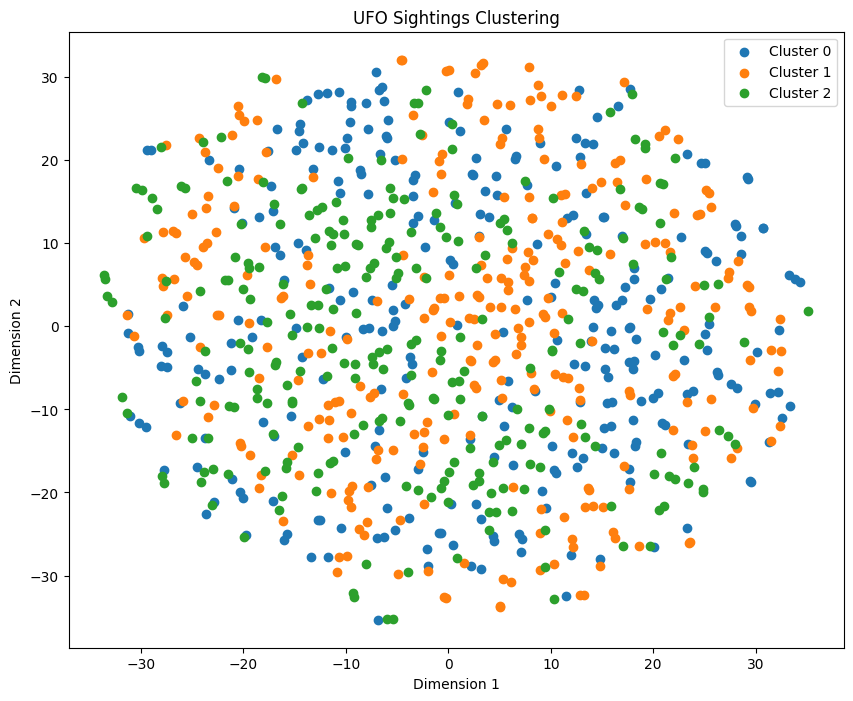

In [73]:
# Install necessary libraries


# Load the RDF data
g = Graph()
g.parse("ufo_knowledge_graph.ttl", format="turtle")

# Function to abbreviate URIs
def abbr(u):
    return u[u.rindex("#")+1:] if "#" in u else u[u.rindex("/")+1:] if "/" in u else u

# Extract triples from the RDF graph
gdata = np.array([np.array([abbr(s), abbr(p), abbr(o)]) for s,p,o in g])
tf = TriplesFactory.from_labeled_triples(gdata)

# Split data into train, test, and validation sets
train, test, validation = tf.split([.6, .2, .2], random_state=42)

# Train the knowledge graph embedding model
result = pipeline(
    training=train,
    testing=test,
    validation=validation,
    model='TransE',
    epochs=10,
    dimensions=128,
    negative_sampler="basic",
    random_seed=42
)

# Extract embeddings
entity_labels = list(train.entity_labeling.all_labels())
embeddings = np.array([result.model.entity_representations[0]()[entity_labels.index(ent)].detach().numpy() for ent in entity_labels])

# Perform KMeans clustering
num_clusters = 3  # You can choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    points = embeddings_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
plt.legend()
plt.title('UFO Sightings Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [71]:

# Step 1: Load RDF data
g = Graph()
g.parse("ufo_knowledge_graph.ttl", format="turtle")

# Step 2: Extract triples from RDFLib graph
triples = []
for s, p, o in g.triples((None, None, None)):
    triples.append((str(s), str(p), str(o)))

# Step 3: Save triples to a CSV file
with open("ufo_triples.csv", "w") as f:
    for triple in triples:
        f.write(f"{triple[0]},{triple[1]},{triple[2]}\n")

# Step 4: Load triples from CSV file into a PyKEEN TriplesFactory
df = pd.read_csv("ufo_triples.csv", header=None)
triples = [tuple(row) for row in df.values]

# Convert triples list to a NumPy array with shape (n, 3)
triples_array = np.array(triples)

# Split the triples into training and testing sets
train_triples, test_triples = train_test_split(triples_array, test_size=0.2, random_state=42)

# Create TriplesFactory for training and testing sets
train_triples_factory = TriplesFactory.from_labeled_triples(train_triples)
test_triples_factory = TriplesFactory.from_labeled_triples(test_triples)

# Step 5: Define and run the PyKEEN pipeline
result = pipeline(
    training=train_triples_factory,
    testing=test_triples_factory,
    model="TransE",  
    random_seed=1234,
    device="cpu"  # Use "cuda" if you have GPU support
)

# Step 6: Perform link prediction using predict_target
head_entity = "https://example.org/ufo/Sighting_US_1"  # Replace with actual URI
relation_label = "https://example.org/ufo/country"   # Replace with actual relation

# Predict the tails given the head and relation
pred = predict_target(
    model=result.model,
    head=head_entity,
    relation=relation_label,
    triples_factory=result.training,
)

# Print the tail predictions
print(pred.df)

# Additional step: Use predict_target to predict relations for given head and tail entities
head_entity = "https://example.org/ufo/Sighting_US_1"  # Replace with actual URI
tail_entity = "https://example.org/ufo/Sighting_US_100"        # Replace with actual URI

pred = predict_target(
    model=result.model,
    head=head_entity,
    tail=tail_entity,
    triples_factory=result.training,
)

# Print the relation predictions
print(pred.filter_triples().df[["relation_label"]])


INFO:pykeen.pipeline.api:Using device: cpu


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/305 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.34s seconds


     tail_id      score                                         tail_label
569      569  -6.105527              https://example.org/ufo/Sighting_US_1
129      129  -7.503781                                         1970-10-10
564      564  -7.782010             https://example.org/ufo/Location_US_96
276      276  -7.879829                                               45.0
235      235  -7.981482                                         37.1536111
..       ...        ...                                                ...
681      681 -11.638745                                       lackland afb
305      305 -11.646967  A bright orange color changing to reddish colo...
753      753 -11.669117            toronto (greater toronto area) (canada)
408      408 -11.792242  green oval shaped light over my local church&#...
320      320 -11.962466            Flashing object above Charleston&#44 SC

[771 rows x 3 columns]
                                      relation_label
6                      